# ECE 570 Assignment 7 Instructions

## **Instructions**
This Jupyter notebook document entitled **Assignment_07_Instructions** contains instructions for doing your assignment exercise.
A second Jupyter notebook document entited **Assignment_07_Exercise** contains all the exercises that you will need to perform.

As you read each section of this instruction, you should try running the associated code snippets. 
The colaboratory environment allows you to run code snippets locally by clicking on the arrow on the left of the code. This is a wonderful feature that allows you to experiment as you read. You should take advantage of this and experiment and test different ideas, so you can become more familiar with the Python and the Jupyter programing environment. 

At the end of each sub-section, there will be exercises to perform. 
You should perform the exercises in the document **Assignment_07_Exercise**, which will contain all your results. 
You can then hand in your results by printing the **Assignment_07_Exercise** document as a pdf with all code and simulation results included.

## Section 1: Using Pytorch to implement autoencoders

In previous deep learning tasks, we only focus on how to implement a classifier by using neural networks. However, neural networks can do much more than this. Autoencoders is one of the easist implementation that allows the neural network to output image-like data.  

Autoencoders are a general class of neural networks that consist of two components: an encoder and a decoder.
The encoder takes the image and encodes it into a low dimensional vector representation. 
The decoder takes the vector and decompresses it into something close to the original image.
Autoencoders have a variety of useful applications including denoising of images.
Moreover, they are just cool because they provide a mechanism to represent complex image content as low dimensional vectors.

Another important feature of autoencoders is that they use unsupervised training. 
In other words, they can be trained without training labels.
This is important because in many cases it may be difficult to obtain labeled training data or ground truth. 

In this section, we will learn how to implement a simple autoencoder using a fully connected neural network. 


---



Again, we are using our old friend the MNIST data. We first download it and construct data loaders for it. Moreover, we create a variable `device` that sets which device we want the neural network to run onto.

**Important**: Be sure to select the GPU device in the colab setup.

In [1]:
import torchvision
import torch

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Images already in [0,1]

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

We are using device name "cuda"




---


In the network structure, the neural network itself consists of two parts. The encoding layer and decoding layer. The encoding layer here is a fully connected network that changes the dimension from **[batch_size x 784]** to **[batch_size x 16]**, and the decoding layer works in the exact opposite way, which is a fully connected network that changes the dimension from **[batch_size x 16]** back to **[batch_size x 784]**. Note, by doing this we are compressing our images to 16 instead of 784 features!!  

We move our neural network to the device we want to run on simply by applying the function `model.to(device)`.
Also, we use a sigmoid activation at the final layer to ensure the output image pixel values are between 0 and 1.

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

latent_feature = 16

class our_AE(nn.Module):
  def __init__(self):
    super(our_AE, self).__init__()

    # encoder
    self.en_fc1 = nn.Linear(in_features=784, out_features=512)
    self.en_fc2 = nn.Linear(in_features=512, out_features=latent_feature)

    # decoder
    self.de_fc1 = nn.Linear(in_features=latent_feature, out_features=512)
    self.de_fc2 = nn.Linear(in_features=512, out_features=784)

  def forward(self, x):

    # encoding layers
    x = x.view(-1, 784)
    x = F.relu(self.en_fc1(x))
    x = F.relu(self.en_fc2(x))

    # decoding layers
    x = F.relu(self.de_fc1(x))
    x = torch.sigmoid(self.de_fc2(x))
    x = x.view(-1, 1, 28, 28)
    return x


AE = our_AE().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')

Here, since the loss function is trying to compare two images. We can select the MSE loss function to calculate the loss. Also, we are selecting the Adam optimizer.


---
Then, as usual, we define our training and test function for the neural network.  
**Note: We move our image tensor to device we want before plugging into the neural network**

In [3]:
def train(epoch, device):

  AE.train() # we need to set the mode for our model

  for batch_idx, (images, _) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    images = images.to(device)
    output = AE(images)
    loss = loss_fn(output, images) # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  AE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
      images = images.to(device)
      output = AE(images)
      test_loss += loss_fn(output, images).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

In [4]:
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 2

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

Epoch 1: [0/60000] Loss: 182.677734375
Epoch 1: [6400/60000] Loss: 55.10847854614258
Epoch 1: [12800/60000] Loss: 51.90985107421875
Epoch 1: [19200/60000] Loss: 46.2443962097168
Epoch 1: [25600/60000] Loss: 40.76873016357422
Epoch 1: [32000/60000] Loss: 32.37171173095703
Epoch 1: [38400/60000] Loss: 35.3834228515625
Epoch 1: [44800/60000] Loss: 30.800918579101562
Epoch 1: [51200/60000] Loss: 29.92618751525879
Epoch 1: [57600/60000] Loss: 29.225738525390625
Test result on epoch 1: Avg loss is 26.908159765625
Epoch 2: [0/60000] Loss: 27.473560333251953
Epoch 2: [6400/60000] Loss: 25.66476821899414
Epoch 2: [12800/60000] Loss: 27.677242279052734
Epoch 2: [19200/60000] Loss: 23.99394989013672
Epoch 2: [25600/60000] Loss: 23.631092071533203
Epoch 2: [32000/60000] Loss: 21.75863265991211
Epoch 2: [38400/60000] Loss: 22.28548812866211
Epoch 2: [44800/60000] Loss: 22.196914672851562
Epoch 2: [51200/60000] Loss: 20.815406799316406
Epoch 2: [57600/60000] Loss: 20.894901275634766
Test result on e

Then, we can print our result by simply selecting several images from the dataset and then forwarding the images using autoencoders.  Note we can move the images on the GPU back to the CPU using the `.cpu()` function of PyTorch tensors.

torch.Size([1000, 1, 28, 28]) torch.Size([1000, 1, 28, 28])


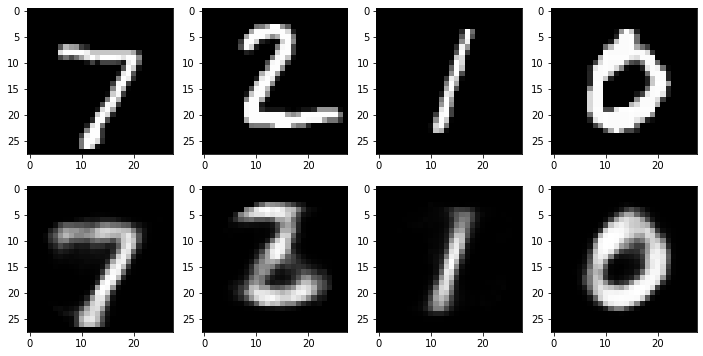

In [5]:
import matplotlib.pyplot as plt

batch_idx, (images, _) = next(enumerate(test_loader))
images = images.to(device)
output = AE(images).cpu().detach()
images = images.cpu()

print(images.size(), output.size())

fig, ax = plt.subplots(2,4)
fig.set_size_inches(12,6)

for idx in range(4):
  ax[0,idx].imshow(images[idx][0], cmap='gray')
  ax[1,idx].imshow(output[idx][0], cmap='gray')

fig.show()

Note: We are only using latent space with size 16 compared to the original data which is 28*28=784. We have achieved a compression rate of 17/784 = 0.02!!!

## Section 2: Convolutional autoencoders (and transpose convolutions)

### Encoders via strided convolutions (that downsample)
Convolutions with a stride greater than 1 will generally reduce the width and height of the image.
Thus, convolutions can be seen as a type of downsampling.
One way to construct the encoder is to downsample the images via convolutions.
Here we give an example of using two convolutional layers with stride of 2 to reduce the dimensionality.

In [6]:
batch_size = 10
n_channels = 3
n_latent = 4
image_size = 4
conv1 = nn.Conv2d(n_channels, 5, kernel_size=2, stride=2)
conv2 = nn.Conv2d(5, n_latent, kernel_size=2, stride=2)

x = torch.randn((batch_size, n_channels, image_size, image_size)) # 
print(f'x shape = {x.shape}')
x = conv1(x)
print(f'x shape = {x.shape}')
x = conv2(x)
print(f'x shape = {x.shape}')
x = x.view(batch_size, -1)
print(f'x shape = {x.shape}') # 4 dimensional latent space based on channels

x shape = torch.Size([10, 3, 4, 4])
x shape = torch.Size([10, 5, 2, 2])
x shape = torch.Size([10, 4, 1, 1])
x shape = torch.Size([10, 4])


### Decoders via transpose convolution / fractionally strided convolution (that upsample)

For the decoders, we need to upsample to go from a latent dimension back to the original dimension.
Thus, we need something like convolutions but that can upsample rather than downsample.
The transposed convolution does exactly this.  The number of input and output channels is similar to the normal convolution, however, the operation does the "transpose" of the convolutions such that a stride of 2 actually increases the output size rather than decreasing.

This is similar to the transpose of a matrix multiplication.  For example, if $A \in R^{20,50}$ and $x\in R^{50}$, then $y = Ax \in R^{20}$--thus going from 50 to 20 dimensions.
However, if we multiply $A^T$ and $y \in R^{20}$, then we get $z = A^Ty \in R^{50}$--thus going from 20 to 50 dimensions.

Note that transpose convolutions are not inverses but rather just upsampling operations (similar to the fact that $A^T$ is not the inverse of $A$ except if $A$ is orthogonal.

While you don't need more information than above to do the exercises, you can see https://arxiv.org/pdf/1603.07285v1.pdf chapter 4 for more information on transpose convolutions.

In practice, we can easily create these transpose convolutions in PyTorch to upsample from the latent space to the original image shape as we show in the example below.
Note that we switch the order of the convolutions and the input/output number of channels, but the transpose convolutions have the same kernel_size and stride as the convolutions original convolutions.

For convolutional autoencoders, usually the encoders use convolutions and the decoder uses transpose convolutions in the reverse order to get back the original shape.

In [7]:
tran_conv2 = nn.ConvTranspose2d(n_latent, 5, kernel_size=2, stride=2)
tran_conv1 = nn.ConvTranspose2d(5, n_channels, kernel_size=2, stride=2)

z = x
print(f'z shape = {z.shape}')
z = z.view(batch_size, n_latent, 1, 1)
print(f'z shape = {z.shape}')
z = tran_conv2(z)
print(f'z shape = {z.shape}')
z = tran_conv1(z)
print(f'z shape = {z.shape}')

z shape = torch.Size([10, 4])
z shape = torch.Size([10, 4, 1, 1])
z shape = torch.Size([10, 5, 2, 2])
z shape = torch.Size([10, 3, 4, 4])


## Section 3: Install extra packages in Colab.

The `!` in Jupyter notebooks executes a bash shell command so you can do things like installing Python modules using `pip`, cloning GitHub repositories using `!git clone ...` or showing the contents of the current directory via `!ls`.  

You probably need packages that is nor avalible here in the colab environment. Here is a example on how to implement this using `pip`.

---

If we need to import the package called `torchsummary`, we only need to use pip to install the package (this will have to be run every time you run the notebook as colab destroys the environment when you close the notebook.

In [8]:
!pip install torchsummary

from torchsummary import summary
summary(AE, (1,784))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                   [-1, 16]           8,208
            Linear-3                  [-1, 512]           8,704
            Linear-4                  [-1, 784]         402,192
Total params: 821,024
Trainable params: 821,024
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 3.13
Estimated Total Size (MB): 3.15
----------------------------------------------------------------


You can actually use the summary function a lot. It helps print your model in a more nicer form.


## Section 4: Customizable transform function and dataloader
Usually when we want to preprocess our dataset. We apply the corresponding transform functions in the data download step. However, what if we want to write our own transform functions? For example, if we want to flip the pixel values how do we apply such transform to the dataset. It turns out you only need to define a new transform class that has the following functions:
* `__init__`: This function initializes your transformer (usually to set parameters of the transformer)
* `__call__`: This function should contain your transform operation
Here is an example on how to create a flip value transform:



In [9]:
import torchvision
import torch
import matplotlib.pyplot as plt

class FlipValue(object):
  def __init__(self, max_value=1):
    self.max_value = max_value
      
  def __call__(self, tensor):
    tensor = self.max_value - tensor
    return tensor

transform_flip = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), FlipValue(1)])

Note that we can just concat our transform with other transforms. 

---

Now, we want to create a paired dataset that extract both the flipped dataset and original dataset at the same time when we call the dataloader. Again, this can be done by creating a new dataset class with the following functions:
* `__init__`: This function is needed to initilize your dataset.
* `__getitem__`: This function is used when you call the class by an index (e.g., `dataset[10]`) .
* `__len__`: This function is called when you apply the `len()` function to your class.

Below is one way to concat two datasets and form a paired dataset.


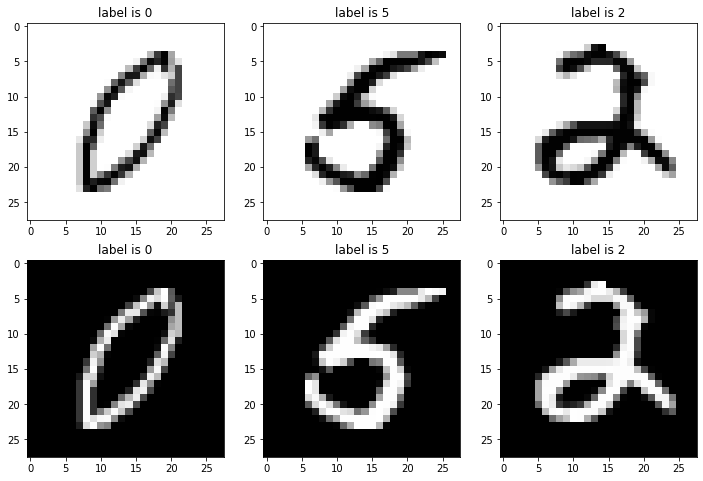

In [10]:
transform_flip = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), FlipValue(1)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_flipped = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_flip)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)

class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)

train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_flipped, train_dataset_original),
                      batch_size=10, shuffle=True)
_, (fliped, original) = next(enumerate(train_loader))

fig,ax = plt.subplots(2,3)
fig.set_size_inches(12,8)
for idx in range(3):
  ax[0,idx].imshow(fliped[0][idx][0], cmap='gray')
  ax[0,idx].set_title(f'label is {fliped[1][idx]}')
  ax[1,idx].imshow(original[0][idx][0], cmap='gray')
  ax[1,idx].set_title(f'label is {original[1][idx]}')
fig.show()